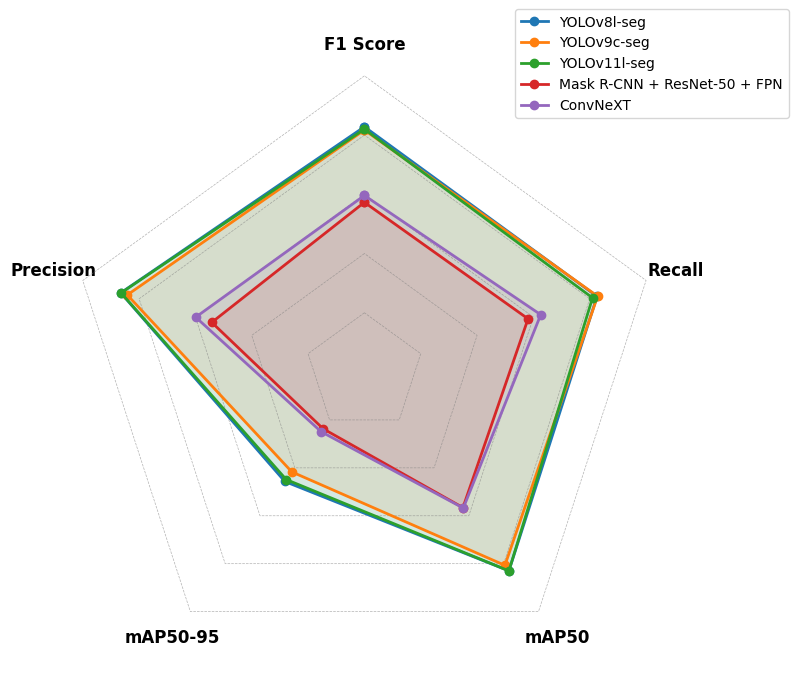

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 설정
models = ["YOLOv8l-seg", "YOLOv9c-seg", "YOLOv11l-seg", "Mask R-CNN + ResNet-50 + FPN", "ConvNeXT"]

# Recall과 mAP50-95 순서 변경
metrics = ["F1 Score", "Precision", "mAP50-95", "mAP50", "Recall"]

# 값도 동일한 순서로 변경 (Recall과 mAP50-95 자리 변경)
values = np.array([
    [0.828, 0.865, 0.457, 0.83, 0.826],  # YOLOv8l-seg
    [0.817, 0.842, 0.417, 0.807, 0.828],  # YOLOv9c-seg
    [0.820, 0.864, 0.449, 0.83, 0.81],  # YOLOv11l-seg
    [0.573, 0.542, 0.237, 0.566, 0.581],  # Mask R-CNN + ResNet-50 + FPN
    [0.596, 0.599, 0.249, 0.568, 0.626]   # ConvNeXT
])

# 방사형 차트 설정
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # 닫힌 도형을 위해 첫 번째 값을 추가

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# 불필요한 배경 제거
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=12, fontweight='bold')
ax.set_yticklabels([])  # Y축 라벨 제거
ax.spines['polar'].set_visible(False)  # 외곽 테두리 제거
ax.grid(False)  # 기본 그리드(회색 원) 제거

# 오각형 가이드라인 추가
for i in np.linspace(0.2, 1, 5):  # 5단계 오각형 가이드라인
    grid_values = [i] * len(metrics)
    grid_values += grid_values[:1]  # 닫힌 형태 만들기
    ax.plot(angles, grid_values, linestyle="dashed", color="gray", linewidth=0.5, alpha=0.6)

# 차트를 똑바로 세우기 (F1 Score를 위쪽에 배치)
ax.set_theta_offset(np.pi / 2)  # 90도 회전 (위쪽이 기준)

# 각 모델의 방사형 차트 플롯
for i, (model, value) in enumerate(zip(models, values)):
    data = value.tolist()
    data += data[:1]  # 닫힌 도형을 만들기 위해 첫 번째 값을 다시 추가
    ax.plot(angles, data, marker='o', linewidth=2, linestyle='solid', label=model)
    ax.fill(angles, data, alpha=0.1)

# 범례 추가
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1), fontsize=10, frameon=True)

# 그래프 출력
plt.show()


In [7]:
import pandas as pd
import numpy as np
from openpyxl import Workbook
from openpyxl.styles import Font, PatternFill, Border, Side, Alignment
from openpyxl.utils import get_column_letter

def create_distribution_table(output_filename="박스_분배_방안.xlsx"):
    # 상수 설정
    TOTAL_BOXES = 1074                 # 총 박스 수
    ITEMS_PER_BOX = 6                  # 박스당 물품 수
    TOTAL_ITEMS = TOTAL_BOXES * ITEMS_PER_BOX  # 총 물품 수 (6444)
    
    # 회사별 세트당 박스 수
    A_BOXES_PER_SET = 68
    B_BOXES_PER_SET = 38
    C_BOXES_PER_SET = 36
    
    # 가능한 모든 조합 계산
    solutions = []
    
    max_a_sets = TOTAL_BOXES // A_BOXES_PER_SET
    max_b_sets = TOTAL_BOXES // B_BOXES_PER_SET
    
    for a in range(max_a_sets + 1):
        for b in range(max_b_sets + 1):
            remaining_boxes = TOTAL_BOXES - (a * A_BOXES_PER_SET) - (b * B_BOXES_PER_SET)
            
            if remaining_boxes >= 0 and remaining_boxes % C_BOXES_PER_SET == 0:
                c = remaining_boxes // C_BOXES_PER_SET
                
                # 각 회사 박스 수
                a_boxes = a * A_BOXES_PER_SET
                b_boxes = b * B_BOXES_PER_SET
                c_boxes = c * C_BOXES_PER_SET
                
                # 총 세트 수
                total_sets = a + b + c
                
                # 각 회사 물품 수
                a_items = a_boxes * ITEMS_PER_BOX
                b_items = b_boxes * ITEMS_PER_BOX
                c_items = c_boxes * ITEMS_PER_BOX
                
                # A회사 세트 비율
                a_set_ratio = 0 if total_sets == 0 else (a / total_sets) * 100
                
                # A회사 박스 비율
                a_box_ratio = 0 if TOTAL_BOXES == 0 else (a_boxes / TOTAL_BOXES) * 100
                
                solutions.append([
                    len(solutions) + 1,  # 방안 번호
                    a,                   # A회사 세트 수
                    b,                   # B회사 세트 수
                    c,                   # C회사 세트 수
                    a_boxes,             # A회사 박스 수
                    b_boxes,             # B회사 박스 수
                    c_boxes,             # C회사 박스 수
                    total_sets,          # 총 세트 수
                    f"{a_set_ratio:.2f}%", # A회사 세트 비율
                    f"{a_box_ratio:.2f}%"  # A회사 박스 비율
                ])
    
    # 워크북 생성
    wb = Workbook()
    ws = wb.active
    ws.title = "박스 분배 방안"
    
    # 헤더 추가
    headers = ["방안", "A회사 세트 수", "B회사 세트 수", "C회사 세트 수", 
              "A회사 박스 수", "B회사 박스 수", "C회사 박스 수", 
              "총 세트 수", "A회사 세트 비율", "A회사 박스 비율"]
    
    for col_idx, header in enumerate(headers, 1):
        cell = ws.cell(row=1, column=col_idx)
        cell.value = header
        cell.font = Font(bold=True)
        cell.alignment = Alignment(horizontal='center')
    
    # 데이터 추가
    for row_idx, solution in enumerate(solutions, 2):
        for col_idx, value in enumerate(solution, 1):
            cell = ws.cell(row=row_idx, column=col_idx)
            cell.value = value
            
            # 숫자 열은 오른쪽 정렬
            if 1 < col_idx < 8:
                cell.alignment = Alignment(horizontal='right')
            
            # 비율 열은 가운데 정렬
            if col_idx > 7:
                cell.alignment = Alignment(horizontal='center')
    
    # 열 너비 조정
    column_widths = [6, 14, 14, 14, 14, 14, 14, 10, 14, 14]
    for i, width in enumerate(column_widths, 1):
        ws.column_dimensions[get_column_letter(i)].width = width
    
    # 테두리 설정
    thin_border = Border(
        left=Side(style='thin'),
        right=Side(style='thin'),
        top=Side(style='thin'),
        bottom=Side(style='thin')
    )
    
    for row in ws.iter_rows(min_row=1, max_row=len(solutions)+1, min_col=1, max_col=len(headers)):
        for cell in row:
            cell.border = thin_border
    
    # 설명 텍스트 추가
    explanation_row = len(solutions) + 3
    ws.cell(row=explanation_row, column=1).value = "설명:"
    ws.cell(row=explanation_row, column=1).font = Font(bold=True)
    
    ws.cell(row=explanation_row + 1, column=1).value = f"- 총 박스 수: {TOTAL_BOXES}개"
    ws.cell(row=explanation_row + 2, column=1).value = f"- 박스당 물품 수: {ITEMS_PER_BOX}개"
    ws.cell(row=explanation_row + 3, column=1).value = f"- 총 물품 수: {TOTAL_ITEMS}개"
    ws.cell(row=explanation_row + 4, column=1).value = "- A회사 세트당 박스 수: 68개"
    ws.cell(row=explanation_row + 5, column=1).value = "- B회사 세트당 박스 수: 38개"
    ws.cell(row=explanation_row + 6, column=1).value = "- C회사 세트당 박스 수: 36개"
    
    # 파일 저장
    wb.save(output_filename)
    print(f"파일이 생성되었습니다: {output_filename}")
    print(f"가능한 분배 방안 수: {len(solutions)}개")

if __name__ == "__main__":
    create_distribution_table()

파일이 생성되었습니다: 박스_분배_방안.xlsx
가능한 분배 방안 수: 14개


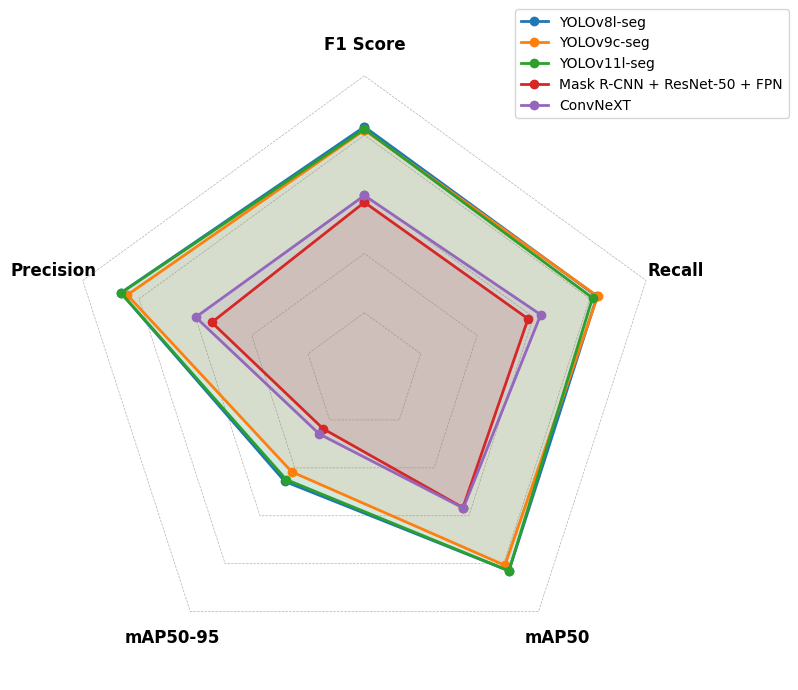

In [21]:
# 1️⃣ 개선된 레이다 차트 (Radar Chart)
import matplotlib.pyplot as plt
import numpy as np

# 데이터 설정
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # 닫힌 도형을 위해 첫 번째 값을 추가

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# 깔끔한 스타일 적용
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=12, fontweight='bold')
ax.set_yticklabels([])
ax.spines['polar'].set_visible(False)
ax.grid(False)

# 보조 가이드라인 추가
for i in np.linspace(0.2, 1, 5):
    grid_values = [i] * len(metrics)
    grid_values += grid_values[:1]
    ax.plot(angles, grid_values, linestyle="dashed", color="gray", linewidth=0.5, alpha=0.6)

# 차트를 똑바로 세우기 (F1 Score를 위쪽에 배치)
ax.set_theta_offset(np.pi / 2)

# 각 모델의 방사형 차트 플롯
for i, (model, value) in enumerate(zip(models, values)):
    data = value.tolist()
    data += data[:1]
    ax.plot(angles, data, marker='o', linewidth=2, linestyle='solid', label=model)
    ax.fill(angles, data, alpha=0.1)

# 범례 추가
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1), fontsize=10, frameon=True)

# 그래프 출력
plt.show()

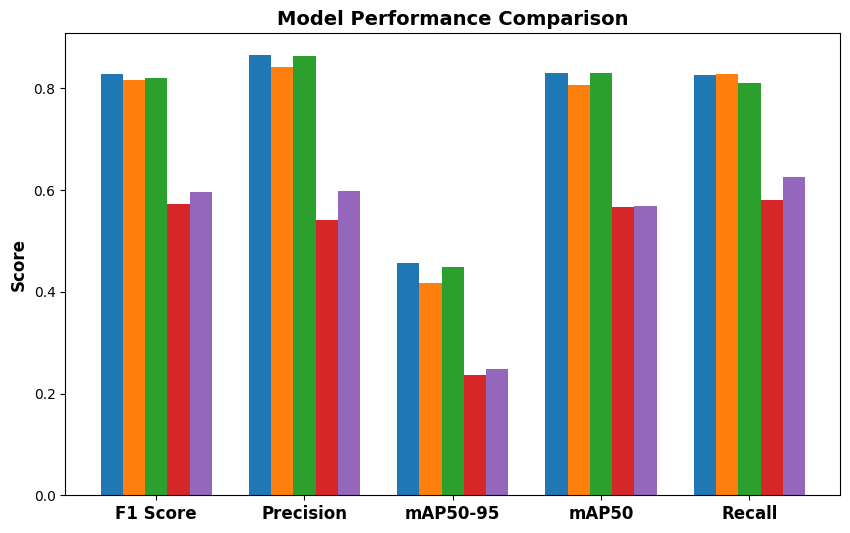

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 설정
models = ["YOLOv8l-seg", "YOLOv9c-seg", "YOLOv11l-seg", "Mask R-CNN + ResNet-50 + FPN", "ConvNeXT"]
metrics = ["F1 Score", "Precision", "mAP50-95", "mAP50", "Recall"]

# 값 설정
values = np.array([
    [0.828, 0.865, 0.457, 0.83, 0.826],  # YOLOv8l-seg
    [0.817, 0.842, 0.417, 0.807, 0.828],  # YOLOv9c-seg
    [0.820, 0.864, 0.449, 0.83, 0.81],  # YOLOv11l-seg
    [0.573, 0.542, 0.237, 0.566, 0.581],  # Mask R-CNN + ResNet-50 + FPN
    [0.596, 0.599, 0.249, 0.568, 0.626]   # ConvNeXT
])

# 막대 그래프 (Grouped Bar Chart) 생성
x = np.arange(len(metrics))  # 지표 개수만큼 x 위치 생성
width = 0.15  # 막대 너비 설정

fig, ax = plt.subplots(figsize=(10, 6))

# 각 모델별로 막대 생성
for i, model in enumerate(models):
    ax.bar(x + i * width, values[i], width, label=model)

# X축 설정
ax.set_xticks(x + width * (len(models) / 2 - 0.5))
ax.set_xticklabels(metrics, fontsize=12, fontweight="bold")

# 그래프 제목 및 라벨
ax.set_ylabel("Score", fontsize=12, fontweight="bold")
ax.set_title("Model Performance Comparison", fontsize=14, fontweight="bold")

# 범례 추가


# 그래프 출력
plt.show()


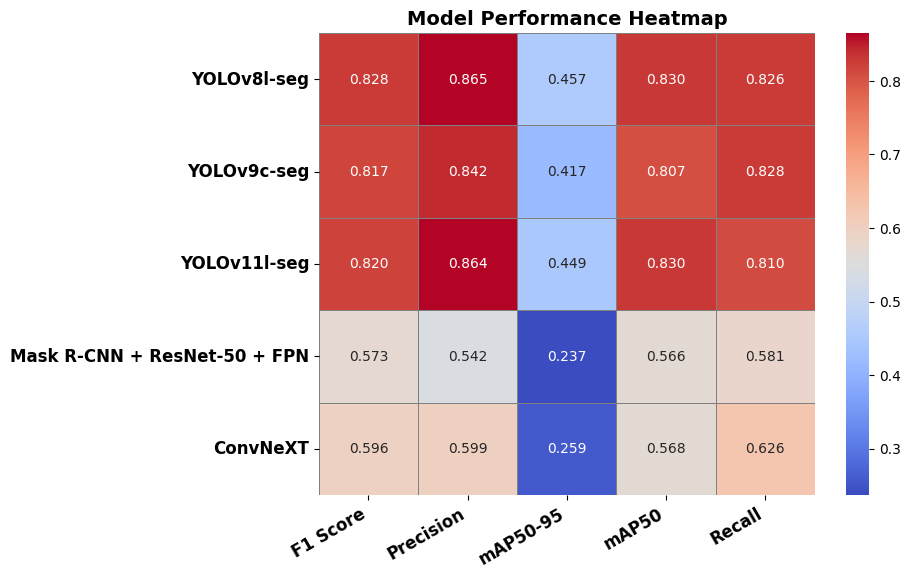

In [17]:
import seaborn as sns

# 히트맵 생성
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(values, annot=True, fmt=".3f", cmap="coolwarm", xticklabels=metrics, yticklabels=models, linewidths=0.5, linecolor="gray")

# 그래프 제목 설정
ax.set_title("Model Performance Heatmap", fontsize=14, fontweight="bold")

# X, Y축 라벨 회전 조정
plt.xticks(rotation=30, ha="right", fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")

# 그래프 출력
plt.show()


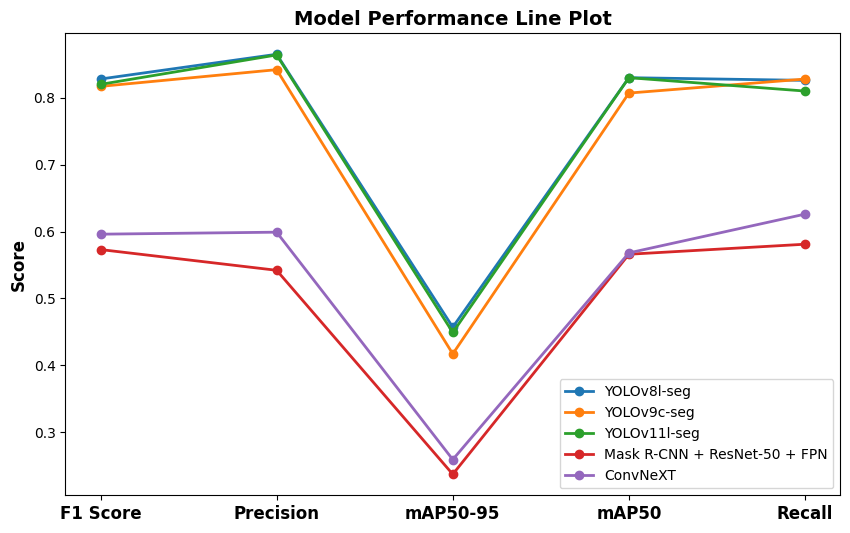

In [18]:
# 선 그래프 (Line Plot) 생성
fig, ax = plt.subplots(figsize=(10, 6))

# 각 모델별로 선 그래프 생성
for i, model in enumerate(models):
    ax.plot(metrics, values[i], marker='o', linestyle='-', linewidth=2, label=model)

# 그래프 제목 및 라벨 설정
ax.set_ylabel("Score", fontsize=12, fontweight="bold")
ax.set_title("Model Performance Line Plot", fontsize=14, fontweight="bold")

# X축 눈금 조정
ax.set_xticks(np.arange(len(metrics)))
ax.set_xticklabels(metrics, fontsize=12, fontweight="bold")

# 범례 추가
ax.legend(loc="lower right", fontsize=10)

# 그래프 출력
plt.show()


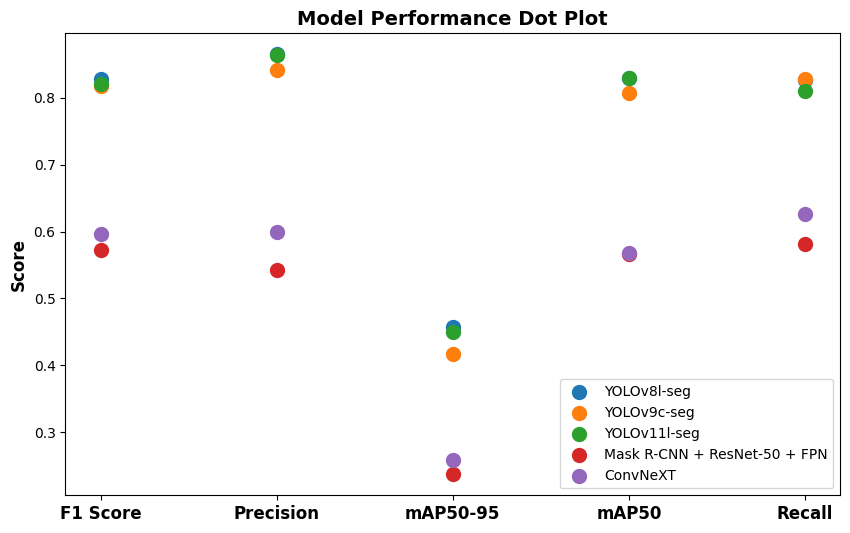

In [19]:
# 점 그래프 (Dot Plot) 생성
fig, ax = plt.subplots(figsize=(10, 6))

# 각 모델별로 점 그래프 생성
for i, model in enumerate(models):
    ax.scatter(metrics, values[i], label=model, s=100)  # s=100은 점 크기 조절

# 그래프 제목 및 라벨 설정
ax.set_ylabel("Score", fontsize=12, fontweight="bold")
ax.set_title("Model Performance Dot Plot", fontsize=14, fontweight="bold")

# X축 눈금 조정
ax.set_xticks(np.arange(len(metrics)))
ax.set_xticklabels(metrics, fontsize=12, fontweight="bold")

# 범례 추가
ax.legend(loc="lower right", fontsize=10)

# 그래프 출력
plt.show()


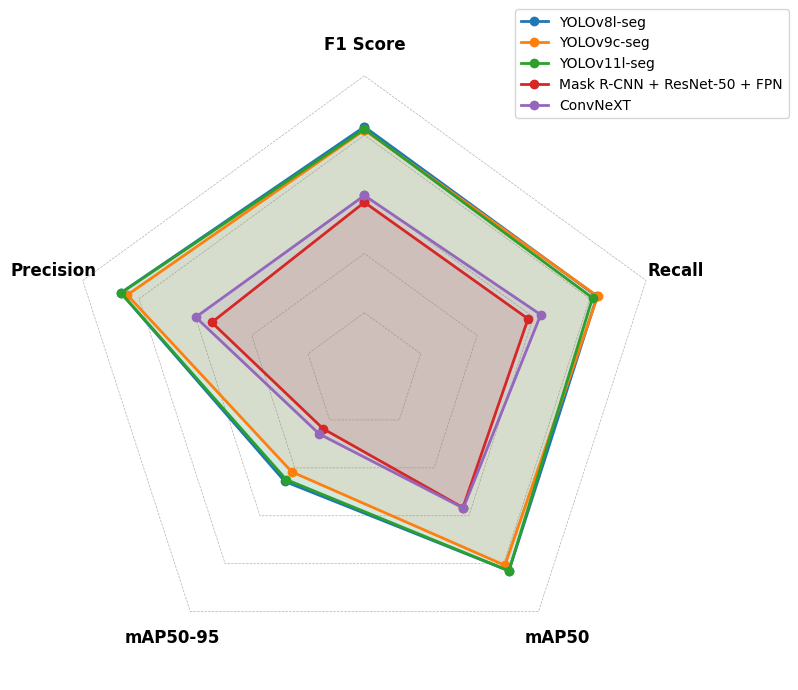